In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import pickle

2023-09-05 12:12:02.532079: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-05 12:12:02.538168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-05 12:12:02.538185: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

In [4]:
tf.random.set_random_seed(0)
np.random.seed(seed=0 )

In [5]:
N_start=0
N_tra=610
T_step=1001
N_bead=300
dim_x=900
N_conf=0
dic=''

Initialize the weights

In [6]:
def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]        
    xavier_stddev = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev,dtype=tf.float32,seed=0), dtype=tf.float32)

In [7]:
def RePU(inputs):
    """Rectified Power Unit Activation

    z->max(0,z)^p
    """
    return (tf.nn.relu(inputs)  )**2


def ShiftedRePU(inputs):
    """Shifted Rectified Power Unit Activation

    z->max(0,z)^p - max(0,z-0.5)^p
    """
    g=(tf.nn.relu(inputs)  )**2-(tf.nn.relu(inputs-0.5)  )**2
    return g

generate $\phi$

Neural network for potential term
$V(x)=\beta  ||x||^2 +\frac{1}{2} \sum_{i=1}^{m} (U_i(x)+\sum_{j=1}^m \gamma_{i,j}x_i)^2$
where $U_i(x)=w \phi_i(x)+b$

In [8]:
def neural_potential(X, weights, biases,Gamma,beta):
    num_layers = len(weights) + 1  
    H=X
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = ShiftedRePU(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = 1/2*tf.reduce_sum( ( tf.matmul(X, Gamma[0])   +(tf.add(tf.matmul(H, W), b)) )**2 ,1, keepdims=True)+beta[0]*tf.reduce_sum(X**2, axis=1, keepdims=True)
    return Y

Neural network for M and W

In [9]:
def neural_A(X, weights, biases ):
    num_layers = len(weights) + 1  
    H=X
    for l in range(0,num_layers-1):
        W = weights[l]
        b = biases[l]
        H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))
#     W = weights[-1]
#     b = biases[-1]
#     Y = tf.add(tf.matmul(H, W), b) 
    return H

In [10]:
def SymmAntiDecomposition( inputs,dim_low):
    A = tf.reshape(inputs, [-1, dim_low, dim_low])#### 1 *  dim_low  *dim_low
    lower_triangle = tf.linalg.band_part(A, -1, 0)
    upper_triangle = tf.linalg.band_part(A, 0, -1)
    symmetric = lower_triangle @ tf.transpose(lower_triangle, [0, 2, 1])  # 1 *  dim_low  *dim_low
    antisymmetric = upper_triangle - tf.transpose(upper_triangle,
                                                  [0, 2, 1])               # 1 *  dim_low  *dim_low
    return symmetric, antisymmetric

In [11]:
def neural_SymmAnti(X,  weights_A, biases_A,dim_low):
    A=neural_A(X, weights_A, biases_A)
    M,W=SymmAntiDecomposition( A,dim_low)
    return M,W   # 1 *  dim_low  *dim_low

Neural network for force term :$f(x)=wx+b$

In [12]:
def neural_force(X, weights, biases ):
    num_layers = len(weights) + 1  
    H=X
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y =  tf.add(tf.matmul(H, W), b)
    return Y

Neural network for the drift term

In [13]:
def neural_RHS(X, weights_potential, biases_potential,Gamma,beta , weights_force, biases_force,weights_A, biases_A,dim_low, alpha):
    """Combination Layer for OnsagerNet

    Takes as input a tuple [M, W, g, f] and outputs
    - (M + W) g - alpha * g + f
    """ 
    M,W=neural_SymmAnti(X,  weights_A, biases_A,dim_low)#  5w *dim_low * dim_low
    V=neural_potential(X, weights_potential, biases_potential,Gamma,beta)
    V_x= tf.gradients(V, X)[0]
    f=neural_force(X, weights_force, biases_force )
    #rhs=-V_x @(M+W)- alpha * V_x + f  
    #rhs=-((M+W)@V_x[:,:,None])[:,:,0]- alpha * V_x + f  
    rhs=-tf.einsum('ijk,ik->ij', M + W, V_x) - alpha * V_x +0* f  #     #  5w *dim_low
    return rhs

Neural network for the low dimension:PCA or autoencoder

In [14]:
def neural_sample(X, weights, biases ):
    num_layers = len(weights) + 1  
    H=X
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    Y =   tf.matmul(H, W) 
    return Y

In [15]:
def generate_data_1trajectory(path,N0,N1):
    N_tra=N1-N0
    a_tra=np.linspace(N0,N1-1,N1-N0,dtype=int)
    data = pickle.load(open(path, 'rb'))
    a_test=np.linspace(0,2,3 ,dtype=int)
    X_all_t0=np.zeros([(T_step-1)*N_tra ,3*N_bead])
    X_all_t1=np.zeros([(T_step-1)*N_tra ,3*N_bead])
    X_all=np.zeros([T_step*N_tra ,3*N_bead])
    L_test=np.linspace(0,T_step-1,T_step,dtype=int)
    for i in a_tra:
        X_all_1=np.zeros([T_step ,3*N_bead])
        W_1=data['Trajectory' + str(i+1) ]
        for j in range(N_bead):
            XX=np.reshape(W_1[:,j],[1001,3])
            X_all_1[:,a_test+3*j]=XX
        X_all[(i-N0)*T_step+L_test,:]=X_all_1
        X_all_t0[(i-N0)*(T_step-1)+L_test[:-1],:]=X_all_1[:-1,:]
        X_all_t1[(i-N0)*(T_step-1)+L_test[:-1],:]=X_all_1[1:,:]
    del(data)
    del(W_1)
    return X_all_t0,X_all_t1,X_all

In [16]:
def generate_Z1_1trajectory(path,N0,N1):
    N_tra=N1-N0
    conf=0
    data = pickle.load(open(path, 'rb'))
    Z1_trajectory_train=data['Wi5' ]
    Z1_trajectory_train=(Z1_trajectory_train-Z_mean)/Z_std
    T_test=np.linspace(N0,N1-1,N1-N0,dtype=int)
    Z1_all=np.reshape(Z1_trajectory_train[conf*N_tra+T_test,:],[N_tra*T_step,1])
    Z1_all_t0=np.reshape(Z1_trajectory_train[conf*N_tra+T_test,:-1],[N_tra*(T_step-1),1])
    Z1_all_t1=np.reshape(Z1_trajectory_train[conf*N_tra+T_test,1:],[N_tra*(T_step-1),1])
    del(data)
    del(Z1_trajectory_train)
    return Z1_all_t0,Z1_all_t1,Z1_all

In [17]:
def neural_autoencoder(X, weights, biases ):
    num_layers = len(weights) + 1  
    H=X
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = np.tanh(np.add(np.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    H =  (np.add(np.matmul(H, W), b))
    return H

In [18]:
def neural_low(X, weights_encoder, biases_encoder,weights_L):
    X_low_PCA=X @weights_L[0]
    X_low_encoder= neural_autoencoder(X,weights_encoder, biases_encoder)
    return X_low_PCA+X_low_encoder

NN for potential

In [19]:
dim_low=3
dim_output=50

layers = [dim_low ] +1* [128] + [dim_output ]
L = len(layers)
weights_potential = [xavier_init([layers[l], layers[l+1]]) for l in range(0, L-1)]    
biases_potential = [tf.Variable( tf.zeros((1, layers[l+1]),dtype=tf.float32)) for l in range(0, L-1)]

layers_L = [dim_low ] +   [dim_output ]
Gamma = [xavier_init([layers_L[0], layers_L[-1]]) ]
beta=[tf.exp( tf.Variable(0,dtype=tf.float32,trainable=True) )]

NN for A

In [20]:
layers_A= [dim_low]   +2*[20]+ [dim_low *dim_low]
L_A = len(layers_A)
weights_A= [xavier_init([layers_A[l], layers_A[l+1]])  for l in range(0, L_A-1)]    
biases_A = [tf.Variable( tf.zeros((1, layers_A[l+1]),dtype=tf.float32)) for l in range(0, L_A-1)]   

NN for force

In [21]:
layers_force = [dim_low] + 0* [20] + [dim_low]
L_force = len(layers_force)
weights_force = [xavier_init([layers_force[l], layers_force[l+1]]) for l in range(0, L_force-1)]   
biases_force = [tf.Variable( tf.zeros((1, layers_force [l+1]),dtype=tf.float32)) for l in range(0, L_force -1)]

NN for low dimension # PCA or auto encoder

In [22]:
#THIS PART IS CRUCIAL - Should not be pre_loaded...
data=pickle.load(open('hyper20000.pkl', 'rb'))
weights_encoder=data["weights_encoder"]
biases_encoder=data["biases_encoder"]

weights_decoder=data["weights_decoder"]
biases_decoder=data["biases_decoder"]

weights_L=data["weights_L"]

In [23]:
t0=0
t1=0.5
dt=(t1-t0)/(T_step)
vect=np.linspace(t0,t1,T_step+1)

In [24]:
sigma=tf.exp(  tf.Variable(np.zeros(dim_low),dtype=tf.float32,trainable=True) )
alpha=  tf.Variable(0.1,dtype=tf.float32,trainable=False) 

meta data

In [25]:
data_meta=pickle.load(open(dic+'ex_train800.pkl', 'rb'))
Z1_ex = data_meta['Wi5'][:610,:]

In [26]:
Z_mean=Z1_ex.mean()
Z_std=Z1_ex.std()
print("DNA elongation mean = %f and standard deviation = %f " % (Z_mean,Z_std))

DNA elongation mean = 208.219945 and standard deviation = 69.796242 


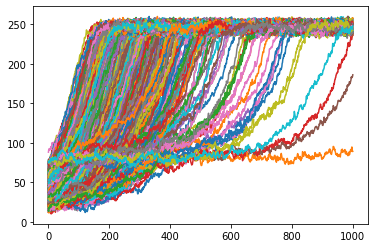

In [27]:
for i in range(N_start,N_tra):
    plt.plot(Z1_ex[i])
    
del(Z1_ex)
del(data_meta)    

In [28]:
loss_trajectory=0
i=N_conf

path_meta =dic+'ex_train800.pkl'
Z1_trajectory_meta=generate_Z1_1trajectory(path_meta,0,N_tra)

In [29]:
Z_t0_meta=Z1_trajectory_meta[0]
Z_t1_meta=Z1_trajectory_meta[1]
del(Z1_trajectory_meta)

In [ ]:
path_meta_tra =dic+'config_train_mean_every.pkl'
X_trajectory_meta=generate_data_1trajectory(path_meta_tra,0,N_tra)#Z0 Z1 Z_all

In [ ]:
aa=neural_autoencoder(X_trajectory_meta[2],weights_encoder, biases_encoder)

In [ ]:
aa1=np.reshape(aa[:,0],[N_tra,T_step])
for i in range(N_tra):
    plt.plot(aa1[i,:]) 
plt.xlabel('$t$',fontsize='20') 
plt.ylabel('$Z2-Z2_{PCA}$  ')#,fontsize='20') 

In [ ]:
aa1=np.reshape(aa[:,1],[N_tra,T_step])
for i in range(N_tra):
    plt.plot(aa1[i,:]) 
plt.xlabel('$t$',fontsize='20') 
plt.ylabel('$Z3-Z3_{PCA}$  ')#,fontsize='20') 

In [ ]:
X_t0_meta=neural_low(X_trajectory_meta[0], weights_encoder, biases_encoder,weights_L  )
X_t1_meta=neural_low(X_trajectory_meta[1], weights_encoder, biases_encoder,weights_L  ) 
X_t_meta=neural_low(X_trajectory_meta[2], weights_encoder, biases_encoder,weights_L  ) 
del(X_trajectory_meta)

In [ ]:
aa1=np.reshape(X_t_meta[:,0],[N_tra,T_step])
for i in range(N_tra):
    plt.plot(aa1[i,:])

In [ ]:
aa2=np.reshape(X_t_meta[:,1],[N_tra,T_step])
for i in range(N_tra):
    plt.plot(aa2[i,:])

In [ ]:
Z_t0_all_meta=np.concatenate((Z_t0_meta,X_t0_meta), axis=1)
Z_t1_all_meta=np.concatenate((Z_t1_meta,X_t1_meta), axis=1)
Z_t0_tf_all_meta=[tf.cast(Z_t0_all_meta[:,j][:,None] , dtype=tf.float32)  for j in range(dim_low) ]
ZZ_t0_tf_all_meta=tf.concat(Z_t0_tf_all_meta,1 )
neural_g_meta=neural_RHS(ZZ_t0_tf_all_meta, weights_potential, biases_potential,Gamma,beta , weights_force, biases_force,weights_A, biases_A,dim_low, alpha)
int_g_meta=   dt/2*( ((Z_t1_all_meta-Z_t0_all_meta)/dt-neural_g_meta)*(1/(sigma[None,:])) )**2+tf.log( sigma[None,:]) #500000,dim_low

In [ ]:
ZZ_t0_tf_all_meta

In [ ]:
int_g_train_vector=tf.reduce_mean(tf.square(  int_g_meta  ) ,0  ) 
int_g_train_vector

In [ ]:
Z_t0_all_meta.shape

In [ ]:
ode_train_meta=(Z_t1_all_meta-Z_t0_all_meta)/dt-neural_g_meta
loss_ode_meta  = tf.reduce_mean(tf.square(  ode_train_meta  )   ) 
loss_sigma_meta= tf.reduce_mean(tf.square(  sigma**2-dt*tf.reduce_mean( tf.square(  ode_train_meta  ) ,0 )  ))

loss_ode=loss_ode_meta
loss_sigma=loss_sigma_meta

In [ ]:
loss_ode_train_vector=tf.reduce_mean(tf.square(  ode_train_meta  ) ,0  ) 
loss_ode_train_vector

In [ ]:
loss_meta=tf.reduce_mean(int_g_meta)  
loss=loss_meta 

In [ ]:
N1_test=0
N2_test=110
path_ex_test = "ex_test.pkl"
path_config_test = "config_test_mean_every.pkl"

In [ ]:
Z1_trajectory_meta_test=generate_Z1_1trajectory(path_ex_test,N1_test,N2_test)
Z_t0_meta_test=Z1_trajectory_meta_test[0]
Z_t1_meta_test=Z1_trajectory_meta_test[1]

In [ ]:
X_trajectory_meta_test=generate_data_1trajectory(path_config_test,N1_test,N2_test)
X_t0_meta_test=neural_low(X_trajectory_meta_test[0], weights_encoder, biases_encoder,weights_L  )
X_t1_meta_test=neural_low(X_trajectory_meta_test[1], weights_encoder, biases_encoder,weights_L ) 
X_t_meta_test=neural_low(X_trajectory_meta_test[2], weights_encoder, biases_encoder,weights_L  ) 
Z_t0_all_meta_test=np.concatenate((Z_t0_meta_test,X_t0_meta_test), axis=1)
Z_t1_all_meta_test=np.concatenate((Z_t1_meta_test,X_t1_meta_test), axis=1)
Z_t0_tf_all_meta_test=[tf.cast(Z_t0_all_meta_test[:,j][:,None] , dtype=tf.float32)  for j in range(dim_low) ]
ZZ_t0_tf_all_meta_test=tf.concat(Z_t0_tf_all_meta_test,1 )
neural_g_meta_test=neural_RHS(ZZ_t0_tf_all_meta_test, weights_potential, biases_potential,Gamma,beta , weights_force, biases_force,weights_A, biases_A,dim_low, alpha)
int_g_meta_test=   dt/2*( ((Z_t1_all_meta_test-Z_t0_all_meta_test)/dt-neural_g_meta_test)*(1/(sigma[None,:])) )**2+tf.log( sigma[None,:]) #500000,dim_low

In [ ]:
int_g_test_vector=tf.reduce_mean(tf.square(  int_g_meta_test  ) ,0  ) 
int_g_test_vector

In [ ]:
ode_test_meta=(Z_t1_all_meta_test-Z_t0_all_meta_test)/dt-neural_g_meta_test
loss_ode_meta_test  = tf.reduce_mean(tf.square(  ode_test_meta  )   ) 
loss_sigma_meta_test= tf.reduce_mean(tf.square(  sigma**2-dt*tf.reduce_mean( tf.square(  ode_test_meta  ) ,0 )  ))

loss_ode_test= loss_ode_meta_test
loss_sigma_test=loss_sigma_meta_test 

In [ ]:
loss_meta_test=tf.reduce_mean(int_g_meta_test)  
loss_test=loss_meta_test 

In [ ]:
loss_ode_test_vector=tf.reduce_mean(tf.square(  ode_test_meta  ) ,0  ) 
loss_ode_test_vector

In [ ]:
optimizer_Adam1 = tf.train.AdamOptimizer(1e-3)
train_op1 = optimizer_Adam1.minimize(loss)

In [54]:
loss_ode_record=[]
loss_sigma_record=[]
loss_ode_test_record=[]
loss_sigma_test_record=[]
loss_record = []
loss_meta_record = [] 

loss_test_record = []
loss_meta_test_record = [] 

loss_ode_train_vector_record=[]
loss_ode_test_vector_record=[]

int_g_train_vector_record=[]
int_g_test_vector_record=[]


loss_reg_record = []
beta_record = []
alpha_record=[]
sigma_record = []
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [ ]:
mkdir result_new

In [55]:
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100001):
        sess.run(train_op1)
        if i % 20000 == 0:
            (loss_result,loss_meta_result, loss_test_result,loss_meta_test_result ) = sess.run([loss,loss_meta ,loss_test,loss_meta_test   ])
            ( loss_ode_result,loss_sigma_result,loss_ode_test_result,loss_sigma_test_result) = sess.run([ loss_ode,loss_sigma,loss_ode_test,loss_sigma_test  ])
            (loss_ode_train_vector_result,loss_ode_test_vector_result,int_g_train_vector_result,int_g_test_vector_result)=sess.run([loss_ode_train_vector,loss_ode_test_vector ,int_g_train_vector,int_g_test_vector  ])
            int_g_train_vector_record.append(int_g_train_vector_result)
            int_g_test_vector_record.append(int_g_test_vector_result)
 
            loss_ode_train_vector_record.append(loss_ode_train_vector_result)
            loss_ode_test_vector_record.append(loss_ode_test_vector_result)

            temp_sigma=sess.run(sigma)
            temp_alpha=sess.run(alpha)
            

            loss_ode_record.append(loss_ode_result) 
            loss_sigma_record.append(loss_sigma_result) 
            loss_ode_test_record.append(loss_ode_test_result) 
            loss_sigma_test_record.append(loss_sigma_test_result) 
            
            
            loss_record.append(loss_result)
            loss_meta_record.append(loss_meta_result) 
            loss_test_record.append(loss_test_result)
            loss_meta_test_record.append(loss_meta_test_result) 
            
            sigma_record.append(temp_sigma)
            alpha_record.append(temp_alpha)
            print ('  %d  %8.2e  %8.2e  %8.2e    %8.2e    %8.2e  %8.2e  %8.2e  %8.2e   %8.2e   %8.2e  %8.2e  %8.2e   %8.2e  %8.2e   %8.2e  %8.2e %8.2e  %8.2e' % (i,loss_ode_result,loss_sigma_result, loss_ode_test_result,loss_sigma_test_result, loss_result,loss_meta_result, loss_test_result,loss_meta_test_result, temp_sigma[0],temp_sigma[1],temp_sigma[2] ,temp_alpha ,loss_ode_train_vector_result[0],loss_ode_train_vector_result[1],loss_ode_train_vector_result[2] ,int_g_train_vector_result[0],int_g_train_vector_result[1],int_g_train_vector_result[2]  ) )
        if i% 50000==0:
            (weights_potential_np,biases_potential_np,Gamma_np,beta_np, weights_A_np,biases_A_np,weights_force_np,biases_force_np)=sess.run([weights_potential,biases_potential,Gamma,beta,weights_A,biases_A,weights_force,biases_force])
            sample_list = {"weights_potential": weights_potential_np, "biases_potential": biases_potential_np,"Gamma":Gamma_np,"beta":beta_np,  "weights_L": weights_L, "sigma":temp_sigma,"weights_A": weights_A_np, "biases_A": biases_A_np,"weights_encoder": weights_encoder , "biases_encoder": biases_encoder ,"weights_decoder": weights_decoder , "biases_decoder": biases_decoder, "weights_force":weights_force, "biases_force":biases_force}
            file_name = './result_new/hyper' + str(i) + '.pkl'
            open_file = open(file_name, "wb")
            pickle.dump(sample_list, open_file)
            open_file.close()


            np.savetxt('./result_new/loss_ode-mat.txt',np.array(loss_ode_record),fmt='%10.5e') 
            np.savetxt('./result_new/loss_sigma-mat.txt',np.array(loss_sigma_record),fmt='%10.5e') 
            np.savetxt('./result_new/loss_ode_test-mat.txt',np.array(loss_ode_test_record),fmt='%10.5e') 
            np.savetxt('./result_new/loss_sigma_test-mat.txt',np.array(loss_sigma_test_record),fmt='%10.5e') 
            
            np.savetxt('./result_new/loss-mat.txt',np.array(loss_record),fmt='%10.5e')
            np.savetxt('./result_new/loss_meta-mat.txt',np.array(loss_meta_record),fmt='%10.5e') 
            np.savetxt('./result_new/loss_test-mat.txt',np.array(loss_test_record),fmt='%10.5e')
            np.savetxt('./result_new/loss_meta_test-mat.txt',np.array(loss_meta_test_record),fmt='%10.5e') 
            np.savetxt('./result_new/loss_ode_train_vector.txt',np.array(loss_ode_train_vector_record),fmt='%10.5e')
            np.savetxt('./result_new/loss_ode_test_vector.txt',np.array(loss_ode_test_vector_record),fmt='%10.5e')
            np.savetxt('./result_new/int_g_train_vector.txt',np.array(int_g_train_vector_record),fmt='%10.5e')
            np.savetxt('./result_new/int_g_test_vector.txt',np.array(int_g_test_vector_record),fmt='%10.5e')
            np.savetxt('./result_new/sigma-mat.txt',np.array(sigma_record),fmt='%10.5e')
            np.savetxt('./result_new/beta-mat.txt',np.array(beta_np),fmt='%10.5e')
            np.savetxt('./result_new/alpha-mat.txt',np.array(alpha_record),fmt='%10.5e')

            np.savetxt('./result_new/Gamma.txt',np.array(Gamma_np[0]),fmt='%10.5e')

2023-09-04 23:22:09.559599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 23:22:09.575931: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-04 23:22:09.575958: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-04 23:22:09.575985: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eleonore-ThinkBook-13s-G2-ITL): /proc/driver/nvidia/version does not exist
2023-09-04 23:22:09.617552: I tensorflow/compiler/mlir/mlir_graph_optimiz

KeyboardInterrupt: 